In [1]:
from rdkit import Chem
 
SMILES_CHARS = [' ',
                  '#', '%', '(', ')', '+', '-', '.', '/',
                  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  '=', '@',
                  'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                  'R', 'S', 'T', 'V', 'X', 'Z',
                  '[', '\\', ']',
                  'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                  't', 'u']
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )
def smiles_encoder( smiles, maxlen=25 ):
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles( smiles ))
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X
 
def smiles_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += index2smi[ i ]
    return smi
    

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import rdkit
from rdkit import Chem
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from rdkit.Chem import AllChem


def smile_fingerprint(smile):
    mol = Chem.MolFromSmiles( smile )
    mfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    fp = mfp.ToBitString()
    fp = fp + "00" # Hack: To pack properly, I need two more characters in the string
    m = np.array(list(fp)).astype(int) # Convert into list of chars, then into an array
    return m

# 'datasets/dd_train.csv'
def read_file(filename):
    #Load the dataset and extract target values
    mdf= pd.read_csv(filename)
    target = mdf['Binding Affinity']
    y = target.values
    mdf.drop(columns='Binding Affinity',inplace=True)
    
    return mdf, y


def create_mol2vec(mdf, model):
    

    mdf['mol'] = mdf['SMILES sequence'].apply(lambda x: rdkit.Chem.MolFromSmiles(x))
    mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
    mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]


    X = np.array([x.vec for x in mdf['mol2vec']])
    
    return X

def create_smilematrix(mdf):
    
    # Convert each SMILE into a matrix
    mat_list = list()
    for smiles in mdf['SMILES sequence']:
        m = smiles_encoder(smiles)
        mat_list.append(m)
    X = np.array(mat_list).reshape(len(mat_list), -1) # Flat array
    return X

def create_smile_fpmatrix(mdf):
    fpmat_list = list()
    for smiles in mdf['SMILES sequence']:
        m = smile_fingerprint(smiles)
        fpmat_list.append(m)
    X = np.array(fpmat_list).reshape(len(fpmat_list), -1) # Flat array
    return X

    


In [3]:
# Setup data for training

mol2vec_model = word2vec.Word2Vec.load('model_300dim.pkl')
mdf, y = read_file('datasets/dd_train.csv')
X1 = create_mol2vec(mdf, mol2vec_model)
X2 = create_smilematrix(mdf)
X3 = create_smile_fpmatrix(mdf)
print(X1.shape, X2.shape, X3.shape)
newX = np.concatenate((X1, X2, X3), axis = 1)
print(newX.shape)

(9000, 300) (9000, 1400) (9000, 2050)
(9000, 3750)


In [4]:
import a4ddcnn as q3
trainX = newX
#trainX = X

input_shape = (25, 150, 1) 
#input_shape = (25, 68, 1) 
#input_shape = (25, 56, 1) 


print(trainX.shape)
cnn_model, m, history = q3.do_naivecnn(trainX, y, input_shape)
#model, m, history = q3.do_naivecnn(X, y, input_shape)




Using TensorFlow backend.


(9000, 3750)
input_shape:  (25, 150, 1)
X shape:  (9000, 25, 150, 1)
Y shape:  (9000,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 150, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 37, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 64)         36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 18, 64)         0         
_________________________________

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


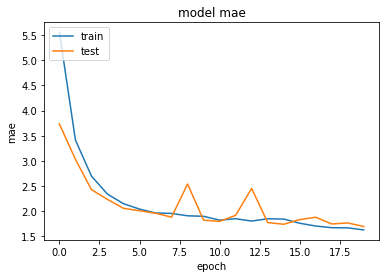

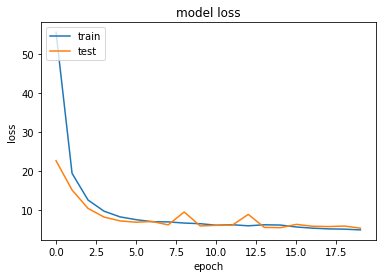

In [5]:
def show_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_history(history)

In [6]:
tdf, y = read_file('datasets/dd_test.csv')
mol2vec_model = word2vec.Word2Vec.load('model_300dim.pkl')

tX1 = create_mol2vec(tdf, mol2vec_model)
tX2 = create_smilematrix(tdf)
tX3 = create_smile_fpmatrix(tdf)

print(tX1.shape, tX2.shape)
testX = np.concatenate((tX1, tX2, tX3), axis = 1)
testX, input_shape1 = m.prepare_data_X(testX, input_shape)
predicted_values = cnn_model.predict(testX)
testy = pd.DataFrame((predicted_values), columns = ['Binding Affinity'])

print(tdf.columns)
tdf.drop(columns = ['mol', 'sentence', 'mol2vec'], inplace = True)

finaldf = pd.concat((tdf, testy), axis = 1)
print(finaldf.shape)

print(finaldf.columns)
finaldf.to_csv('dd_submission_cnn.csv')

(2500, 300) (2500, 1400)
Index(['SMILES sequence', 'mol', 'sentence', 'mol2vec'], dtype='object')
(2500, 2)
Index(['SMILES sequence', 'Binding Affinity'], dtype='object')


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluation(model, X_test, y_test, draw = False):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    if (draw == True):
        plt.figure(figsize=(15, 10))
        plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
        plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
        plt.legend()
        plt.ylabel('logP')
        plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
        plt.show()
    
        print('MAE score:', round(mae, 4))
        print('MSE score:', round(mse,4))
        
    return round(mae, 4), round(mse, 4)


def evaluate_regressor(X, y, reg, train_df):
    if (train_df is not None):
        mdf = pd.DataFrame(X)
        df = pd.concat((mdf, train_df), axis=1)
    else:
        df = X
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=.1, random_state=1)
    reg.fit(X_train, y_train)
    return evaluation(reg, X_test, y_test)


def all_regressors(X, y, train_df):
    reglist = [
                ('randomforest', RandomForestRegressor(max_depth=2, random_state=0)),
                ('adaboost', AdaBoostRegressor(n_estimators=100, learning_rate = 0.5, random_state=0)),
                ('ridge', RidgeCV(cv=5)),
                ('linearregression', LinearRegression())
                ]
    for (name, reg) in reglist:
        mae1, mse1 = evaluate_regressor(X, y, reg, None)
        mae2, mse2 = evaluate_regressor(X, y, reg, train_df)
        print(name)
        print("--- (Without additional data)", " MSE = ", mse1, " MAE = ", mae1)
        print("--- (With    additional data)", " MSE = ", mse2, " MAE = ", mae2)
        



In [8]:
'''
all_regressors(trainX, y, None)

from sklearn.metrics import mean_squared_error
mean_squared_error(m.cnn_params.y_train, predicted_values)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
'''


'\nall_regressors(trainX, y, None)\n\nfrom sklearn.metrics import mean_squared_error\nmean_squared_error(m.cnn_params.y_train, predicted_values)\nprint(X.shape)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)\n'